In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from data_parsing import load_trajectories
from functools import partial, reduce
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
# from glob import glob
# import os

In [36]:
trajectories, status = load_trajectories('data/MITxPRO+AMxB+1T2018/edges', 'data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#trajectories = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL')
#id_and_performance = pd.read_csv('data/MITxPRO-AMxB-1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#id_and_performance.iloc[0]
#id_and_performance

In [37]:
# AM_modules = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-modules.txt', sep='\t', encoding='utf-16')

Maximum trajectory identified by number of clicks:  3483


Text(0, 0.5, 'Count of students')

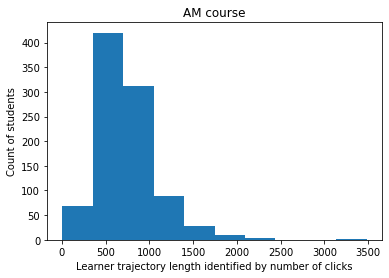

In [38]:
traj_lengths = trajectories.map(len).values
plt.hist(traj_lengths)
print("Maximum trajectory identified by number of clicks: ", max(traj_lengths))
plt.title('AM course')
plt.xlabel('Learner trajectory length identified by number of clicks')
plt.ylabel('Count of students')

## data generators 

In [39]:
index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)

incoming_traj = []
outgoing_traj = []

# this split assumes that we don't need to rebalance for unequal category weights
n_valid = int(2*np.sqrt(len(trajectories)))
n_train = len(trajectories) - n_valid
success_rate = status[index[:n_train]].sum() / n_train

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

def data_generator(start, stop, use_status):
     while True:
        for i in range(start, stop):        
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            y = outgoing_traj[index[i]].reshape(1,-1)
            if use_status:
                yield [x,s],y
            else:
                yield x,y

train_generator_simp = partial(data_generator, 0, n_train, False)
valid_generator_simp = partial(data_generator, n_train, n_train+n_valid, False)
train_generator_cond = partial(data_generator, 0, n_train, True)
valid_generator_cond = partial(data_generator, n_train, n_train+n_valid, True)
success_rate

0.7597701149425288

## Define models

In [40]:
hidden_dim = 30
embedding_dim = 30
# turning trajectories into sets of URLs
optimizer = Adam(learning_rate=0.001)
number_of_URL = max(trajectories.sum()) + 1
#number_of_URL = 1121

In [41]:
input_ = Input(shape=(None,), name='history')
embed = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed)

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(rnn)

model_simp = Model(inputs=input_, outputs=predicted_URL, name='Simple_model')
model_simp.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model_simp.summary()

Model: "Simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
history (InputLayer)         [(None, None)]            0         
_________________________________________________________________
URL_embedding (Embedding)    (None, None, 30)          22620     
_________________________________________________________________
LSTM (LSTM)                  (None, None, 30)          7320      
_________________________________________________________________
Predicted_URL (Dense)        (None, None, 754)         23374     
Total params: 53,314
Trainable params: 53,314
Non-trainable params: 0
_________________________________________________________________


In [42]:
input_x = Input(shape=(None,), name='history')
input_s = Input(shape=(None,), name='status')
embed_x = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_x)
embed_s = Embedding(2, hidden_dim, embeddings_initializer='ones', name='Status_embedding')(input_s)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed_x)
masked = Multiply()([rnn, embed_s])

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(masked)

model_cond = Model(inputs=[input_x, input_s], outputs=predicted_URL, name='Conditional_model')
model_cond.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model_cond.summary()

Model: "Conditional_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
history (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
URL_embedding (Embedding)       (None, None, 30)     22620       history[0][0]                    
__________________________________________________________________________________________________
status (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, None, 30)     7320        URL_embedding[0][0]              
__________________________________________________________________________________

## Run models

In [21]:
#model_simp.load_weights('weights_simp.h5')
#model_cond.load_weights('/Users/rsciagli/documents/Y390_dev/weights_improvement/hid_dim30_Lrate_0001_w-improvement-167-1.70.hdf5', by_name=True)

In [ ]:
filepath="AM_cond_hiddim30-.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model_cond.fit_generator(train_generator_cond(), 
                    validation_data=valid_generator_cond(),
                    callbacks=callbacks_list,
                    steps_per_epoch = n_train, #batch size is inherently 1 via generator
                    validation_steps= n_valid,
                    epochs=500,
                    verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 870 steps, validate for 60 steps
Epoch 1/500
869/870 [============================>.] - ETA: 0s - loss: 4.6691 - acc: 0.1281
Epoch 00001: val_loss improved from inf to 2.91263, saving model to AM_cond_hiddim30-.hdf5
870/870 [==============================] - 360s 414ms/step - loss: 4.6669 - acc: 0.1284 - val_loss: 2.9126 - val_acc: 0.3440
Epoch 2/500
869/870 [============================>.] - ETA: 0s - loss: 2.2844 - acc: 0.4724
Epoch 00002: val_loss improved from 2.91263 to 2.22160, saving model to AM_cond_hiddim30-.hdf5
870/870 [==============================] - 289s 333ms/step - loss: 2.2836 - acc: 0.4726 - val_loss: 2.2216 - val_acc: 0.4997
Epoch 3/500
869/870 [============================>.] - ETA: 0s - loss: 1.9276 - acc: 0.5465
Epoch 00003: val_loss improved from 2.22160 to 2.07388, saving model to AM_cond_hiddim30-.hdf5
870/870 [==============================] - 289s 332ms/step - loss: 1.9270 - acc: 0.5467 - val_loss: 

Epoch 27/500
869/870 [============================>.] - ETA: 0s - loss: 1.5635 - acc: 0.6083
Epoch 00027: val_loss improved from 1.83466 to 1.83274, saving model to AM_cond_hiddim30-.hdf5
870/870 [==============================] - 270s 311ms/step - loss: 1.5629 - acc: 0.6085 - val_loss: 1.8327 - val_acc: 0.5732
Epoch 28/500
869/870 [============================>.] - ETA: 0s - loss: 1.5606 - acc: 0.6088
Epoch 00028: val_loss improved from 1.83274 to 1.83099, saving model to AM_cond_hiddim30-.hdf5
870/870 [==============================] - 271s 311ms/step - loss: 1.5601 - acc: 0.6090 - val_loss: 1.8310 - val_acc: 0.5734
Epoch 29/500
869/870 [============================>.] - ETA: 0s - loss: 1.5579 - acc: 0.6093
Epoch 00029: val_loss improved from 1.83099 to 1.82933, saving model to AM_cond_hiddim30-.hdf5
870/870 [==============================] - 271s 311ms/step - loss: 1.5574 - acc: 0.6095 - val_loss: 1.8293 - val_acc: 0.5738
Epoch 30/500
869/870 [============================>.] - ETA: 

869/870 [============================>.] - ETA: 0s - loss: 1.5169 - acc: 0.6157
Epoch 00053: val_loss improved from 1.80838 to 1.80786, saving model to AM_cond_hiddim30-.hdf5
870/870 [==============================] - 292s 335ms/step - loss: 1.5164 - acc: 0.6159 - val_loss: 1.8079 - val_acc: 0.5789
Epoch 54/500
869/870 [============================>.] - ETA: 0s - loss: 1.5158 - acc: 0.6158
Epoch 00054: val_loss improved from 1.80786 to 1.80739, saving model to AM_cond_hiddim30-.hdf5
870/870 [==============================] - 321s 369ms/step - loss: 1.5152 - acc: 0.6159 - val_loss: 1.8074 - val_acc: 0.5788
Epoch 55/500
869/870 [============================>.] - ETA: 0s - loss: 1.5147 - acc: 0.6160
Epoch 00055: val_loss improved from 1.80739 to 1.80696, saving model to AM_cond_hiddim30-.hdf5
870/870 [==============================] - 423s 487ms/step - loss: 1.5142 - acc: 0.6161 - val_loss: 1.8070 - val_acc: 0.5791
Epoch 56/500
869/870 [============================>.] - ETA: 0s - loss: 1.

## Sample trajectory creation 

In [23]:
proposed_traj = [0]
visit_count = defaultdict(int)
max_allowed_visits = 25

while len(proposed_traj) < 1000 and (len(proposed_traj) == 1 or proposed_traj[-1] != 0):
    x = np.array(proposed_traj).reshape(1,-1)
    #run with s = np.ones(x.shpae) for successful
    s = np.ones(x.shape)
    for url in reversed(np.argsort(model_cond.predict([x,s])[0,-1])):
        if visit_count[url] < max_allowed_visits:
            proposed_traj.append(url)
            visit_count[url] += 1
            break
    #predicted = np.argmax(model.predict(x)[0,-1])
    print(url)
    
print(proposed_traj)

cert_traj = pd.DataFrame(proposed_traj)
cert_traj.to_csv('AM_cert_traj_hid_dim30.csv', header = ['certificate trajectory'], index = False)

699
699
699
699
699
699
699
699


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fa3b0fd0680>
Traceback (most recent call last):
  File "/Users/rsciagli/opt/anaconda3/envs/dataweekends/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/Users/rsciagli/opt/anaconda3/envs/dataweekends/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


699
699
699
699
699
699
699


KeyboardInterrupt: 

## Probability estimation

In [29]:
def score_traj(sample_traj):
    x = np.array(sample_traj[:-1]).reshape(1,-1)
    successful = np.ones(x.shape)
    unsuccessful = np.zeros(x.shape)
    cond_prob_successful = np.array(model_cond([x, successful])).reshape(-1, number_of_URL)
    cond_prob_unsuccessful = np.array(model_cond([x, unsuccessful])).reshape(-1, number_of_URL)

    score_s = []
    score_u = []

    for choice, prob_s, prob_u in zip(sample_traj[1:], cond_prob_successful, cond_prob_unsuccessful):
        score_s.append(np.log(prob_s[choice]))
        score_u.append(np.log(prob_u[choice]))
    return score_s, score_u



In [30]:
def predict_success(traj):
    score_s, score_u = score_traj(traj)
    evidence_s = np.log(success_rate) + np.sum(score_s)
    evidence_u = np.log(1 - success_rate) + np.sum(score_u)
    prob_of_success = 1 / (1 + np.exp(evidence_u - evidence_s))
    return prob_of_success

In [34]:
for i in range(n_train, n_train+n_valid):
    user = index[i]
    traj = trajectories.iloc[user]
    ground_truth = status[user]
    print(ground_truth, predict_success(traj))

1 0.7930744869709381
1 0.810186779650193
1 0.7941541595398978
1 0.8296374822253005
1 0.7897698562413029
1 0.7990590066513582
1 0.797644092243031
1 0.8101116783542441
1 0.8023316312673971
1 0.7855642760177172
1 0.8396095541138673
0 0.7921514691972364
1 0.825456610290981
1 0.7929943449643936
1 0.8376270903286283
0 0.7839146395036175
1 0.8283916423422953
1 0.813320512112722
1 0.7988237028649319
1 0.8254566102912432
0 0.7860163176236256
1 0.7836664027967694
1 0.7918699486701074
0 0.7805878506977747
1 0.7996854760080317
1 0.7867135625026914
1 0.7967757686942963
1 0.821982545567871
1 0.7999200242933696
1 0.7712287385625282
1 0.806556235485551
1 0.8009340200089168
1 0.8021767070382738
1 0.8243281374074243
1 0.8146512844891796
1 0.8022541805850851
1 0.8171449468416626
1 0.8017889963058618
0 0.7988237028649319
1 0.7943935192457867
1 0.7940743271130337
1 0.7956666195154496
0 0.7968548217601484
1 0.805181241321482
1 0.7896076683366343
1 0.7876950865510524
0 0.7876134190563315
0 0.7878175447779102

In [ ]:
# # user list key - session level
# AM_userList = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv')
# AM_userList

# # learning pathway network edge lists - edge list for each student in the course that represent a directed 
# # transitions networks  of students pathway through the courses content modules.  this is all students.
# AM_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-edges-cohort.csv')
# AM_edgelist[:5]

In [ ]:
incoming_traj[0].shape

In [ ]:
model.predict([0,1,3,4,5,6])[0,-1].tolist()

In [ ]:
x = np.array([0,1,2,3,4,5,6]).reshape(1,-1)
s = np.zeros(x.shape)
model2.predict([x,s])[0,-1].tolist()

In [ ]:
np.argsort([7,5,1,2])

In [ ]:
# node list of all students' learning pathway networks
AM_nodelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
AM_nodelist

In [ ]:
# appendix to the node list that provides a set of XY coordinates to generate a common layout for all networks 
# produced in the analysis.  force atlas with parameterization <- what is this?
AM_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-coordinates-FA2.csv')
AM_node_coord[:5]

In [ ]:
# student identifiers and performance statistics, certification, and enrollment data
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
AM_id_and_performance['certGrp'].unique()

In [ ]:
# meta data includes the course title, run dates
LaaL_meta = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-meta.csv')
LaaL_meta

In [ ]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data

# LaaL_edgelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules.csv')
# LaaL_edgelist

LaaL_modules = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules00.csv')
len(LaaL_modules)
LaaL_modules[460:470]

In [ ]:
LaaL_edelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

In [ ]:
LaaL_nodelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
LaaL_nodelist[:5]

In [ ]:
LaaL_node_coord = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes-coordinates-FA2.csv')
LaaL_node_coord[:5]

In [ ]:
LaaL_id_and_performance = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
LaaL_id_and_performance[:5]

count = LaaL_id_and_performance[LaaL_id_and_performance['certGrp']== 'Certified (< 65% Grade)']
len(count)